In [ ]:
# default_exp data.preprocessing

# Data preprocessing

> Functions used to preprocess time series (both X and y).

In [ ]:
#export
import re
import sklearn
from fastcore.transform import Transform, Pipeline
from fastai.data.transforms import Categorize
from fastai.data.load import DataLoader
from fastai.tabular.core import df_shrink_dtypes, make_date
from tsai.imports import *
from tsai.utils import *
from tsai.data.core import *
from tsai.data.preparation import *

In [ ]:
from tsai.data.external import get_UCR_data
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

In [ ]:
#export
class ToNumpyCategory(Transform):
    "Categorize a numpy batch"
    order = 90

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def encodes(self, o: np.ndarray):
        self.type = type(o)
        self.cat = Categorize()
        self.cat.setup(o)
        self.vocab = self.cat.vocab
        return np.asarray(stack([self.cat(oi) for oi in o]))

    def decodes(self, o: np.ndarray):
        return stack([self.cat.decode(oi) for oi in o])

    def decodes(self, o: torch.Tensor):
        return stack([self.cat.decode(oi) for oi in o])

In [ ]:
t = ToNumpyCategory()
y_cat = t(y)
y_cat[:10]

array([3, 2, 2, 3, 2, 4, 0, 5, 2, 1])

In [ ]:
test_eq(t.decode(tensor(y_cat)), y)
test_eq(t.decode(np.array(y_cat)), y)

In [ ]:
#export
class OneHot(Transform): 
    "One-hot encode/ decode a batch"
    order = 90
    def __init__(self, n_classes=None, **kwargs): 
        self.n_classes = n_classes
        super().__init__(**kwargs)
    def encodes(self, o: torch.Tensor): 
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return torch.eye(self.n_classes)[o]
    def encodes(self, o: np.ndarray): 
        o = ToNumpyCategory()(o)
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return np.eye(self.n_classes)[o]
    def decodes(self, o: torch.Tensor): return torch.argmax(o, dim=-1)
    def decodes(self, o: np.ndarray): return np.argmax(o, axis=-1)

In [ ]:
oh_encoder = OneHot()
y_cat = ToNumpyCategory()(y)
oht = oh_encoder(y_cat)
oht[:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
n_classes = 10
n_samples = 100

t = torch.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oht = oh_encoder(t)
test_eq(oht.shape, (n_samples, n_classes))
test_eq(torch.argmax(oht, dim=-1), t)
test_eq(oh_encoder.decode(oht), t)

In [ ]:
n_classes = 10
n_samples = 100

a = np.random.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oha = oh_encoder(a)
test_eq(oha.shape, (n_samples, n_classes))
test_eq(np.argmax(oha, axis=-1), a)
test_eq(oh_encoder.decode(oha), a)

In [ ]:
#export
class TSNan2Value(Transform):
    "Replaces any nan values by a predefined value or median"
    order = 90
    def __init__(self, value=0, median=False, by_sample_and_var=True, sel_vars=None):
        store_attr()
        if not ismin_torch("1.8"):
            raise ValueError('This function only works with Pytorch>=1.8.')

    def encodes(self, o:TSTensor):
        if self.sel_vars is not None: 
            mask = torch.isnan(o[:, self.sel_vars])
            if mask.any() and self.median:
                if self.by_sample_and_var:
                    median = torch.nanmedian(o[:, self.sel_vars], dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1])
                    o[:, self.sel_vars][mask] = median[mask]
                else:
                    o[:, self.sel_vars] = torch.nan_to_num(o[:, self.sel_vars], torch.nanmedian(o[:, self.sel_vars]))
            o[:, self.sel_vars] = torch.nan_to_num(o[:, self.sel_vars], self.value)
        else:
            mask = torch.isnan(o)
            if mask.any() and self.median:
                if self.by_sample_and_var:
                    median = torch.nanmedian(o, dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1])
                    o[mask] = median[mask]
                else:
                    o = torch.nan_to_num(o, torch.nanmedian(o))
            o = torch.nan_to_num(o, self.value)
        return o


    
Nan2Value = TSNan2Value

In [ ]:
o = TSTensor(torch.randn(16, 10, 100))
o[0,0] = float('nan')
o[o > .9] = float('nan')
o[[0,1,5,8,14,15], :, -20:] = float('nan')
nan_vals1 = torch.isnan(o).sum()
o2 = Pipeline(TSNan2Value(), split_idx=0)(o.clone())
o3 = Pipeline(TSNan2Value(median=True, by_sample_and_var=True), split_idx=0)(o.clone())
o4 = Pipeline(TSNan2Value(median=True, by_sample_and_var=False), split_idx=0)(o.clone())
nan_vals2 = torch.isnan(o2).sum()
nan_vals3 = torch.isnan(o3).sum()
nan_vals4 = torch.isnan(o4).sum()
test_ne(nan_vals1, 0)
test_eq(nan_vals2, 0)
test_eq(nan_vals3, 0)
test_eq(nan_vals4, 0)

In [ ]:
o = TSTensor(torch.randn(16, 10, 100))
o[o > .9] = float('nan')
o = TSNan2Value(median=True, sel_vars=[0,1,2,3,4])(o)
test_eq(torch.isnan(o[:, [0,1,2,3,4]]).sum().item(), 0)

In [ ]:
# export
class TSStandardize(Transform):
    """Standardizes batch of type `TSTensor`

    Args:
        - mean: you can pass a precalculated mean value as a torch tensor which is the one that will be used, or leave as None, in which case
            it will be estimated using a batch.
        - std: you can pass a precalculated std value as a torch tensor which is the one that will be used, or leave as None, in which case
            it will be estimated using a batch. If both mean and std values are passed when instantiating TSStandardize, the rest of arguments won't be used.
        - by_sample: if True, it will calculate mean and std for each individual sample. Otherwise based on the entire batch.
        - by_var:
            * False: mean and std will be the same for all variables.
            * True: a mean and std will be be different for each variable.
            * a list of ints: (like [0,1,3]) a different mean and std will be set for each variable on the list. Variables not included in the list
            won't be standardized.
            * a list that contains a list/lists: (like[0, [1,3]]) a different mean and std will be set for each element of the list. If multiple elements are
            included in a list, the same mean and std will be set for those variable in the sublist/s. (in the example a mean and std is determined for
            variable 0, and another one for variables 1 & 3 - the same one). Variables not included in the list won't be standardized.
        - by_step: if False, it will standardize values for each time step.
        - eps: it avoids dividing by 0
        - use_single_batch: if True a single training batch will be used to calculate mean & std. Else the entire training set will be used.
    """

    parameters, order = L('mean', 'std'), 90
    _setup = True # indicates it requires set up
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, by_step=False, eps=1e-8, use_single_batch=True, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self._setup = (mean is None or std is None) and not by_sample
        self.eps = eps
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var: drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        if by_var and is_listy(by_var):
            self.list_axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes]) + (1,)
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if self.mean is not None or self.std is not None:
            pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
               self.verbose)

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                mean = torch.zeros(*shape, device=o.device)
                std = torch.ones(*shape, device=o.device)
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    mean[:, v] = torch_nanmean(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True)
                    std[:, v] = torch.clamp_min(torch_nanstd(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True), self.eps)
            else:
                mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
            self.mean, self.std = mean, std
            if len(self.mean.shape) == 0:
                pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)
            else:
                pv(f'{self.__class__.__name__} mean shape={self.mean.shape}, std shape={self.std.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)
            self._setup = False
        elif self.by_sample: self.mean, self.std = torch.zeros(1), torch.ones(1)

    def encodes(self, o:TSTensor):
        if self.by_sample:
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                mean = torch.zeros(*shape, device=o.device)
                std = torch.ones(*shape, device=o.device)
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    mean[:, v] = torch_nanmean(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True)
                    std[:, v] = torch.clamp_min(torch_nanstd(o[:, v], dim=self.axes if len(v) == 1 else self.list_axes, keepdim=True), self.eps)
            else:
                mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
            self.mean, self.std = mean, std
        return (o - self.mean) / self.std

    def decodes(self, o:TSTensor):
        if self.mean is None or self.std is None: return o
        return o * self.std + self.mean

    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, batch_tfms=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
from tsai.data.validation import TimeSplitter
X_nan = np.random.rand(100, 5, 10)
idxs = np.random.choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 0] = float('nan')
idxs = np.random.choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 1, -10:] = float('nan')
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
test_eq(torch.isnan(dls.after_batch[0].mean).sum(), 0)
test_eq(torch.isnan(dls.after_batch[0].std).sum(), 0)
xb = first(dls.train)[0]
test_ne(torch.isnan(xb).sum(), 0)
test_ne(torch.isnan(xb).sum(), torch.isnan(xb).numel())
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
xb = first(dls.train)[0]
test_eq(torch.isnan(xb).sum(), 0)

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128], inplace=True)
xb, yb = dls.train.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = dls.valid.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True, by_var=False, verbose=False)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128], inplace=False)
xb, yb = dls.train.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = dls.valid.one_batch()
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
#export

@patch
def mul_min(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.min(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    min_x = x
    for ax in axes: min_x, _ = min_x.min(ax, keepdim)
    return retain_type(min_x, x)


@patch
def mul_max(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.max(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    max_x = x
    for ax in axes: max_x, _ = max_x.max(ax, keepdim)
    return retain_type(max_x, x)


class TSNormalize(Transform):
    "Normalizes batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90
    _setup = True # indicates it requires set up
    def __init__(self, min=None, max=None, range=(-1, 1), by_sample=False, by_var=False, by_step=False, clip_values=True, 
                 use_single_batch=True, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.min = tensor(min) if min is not None else None
        self.max = tensor(max) if max is not None else None
        self._setup = (self.min is None and self.max is None) and not by_sample
        self.range_min, self.range_max = range
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var: drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        if by_var and is_listy(by_var):
            self.list_axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes]) + (1,)
        self.clip_values = clip_values
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if self.min is not None or self.max is not None:
            pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', self.verbose)
            
    @classmethod
    def from_stats(cls, min, max, range_min=0, range_max=1): return cls(min, max, range_min, range_max)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                _min = torch.zeros(*shape, device=o.device) + self.range_min
                _max = torch.zeros(*shape, device=o.device) + self.range_max
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    _min[:, v] = o[:, v].mul_min(self.axes if len(v) == 1 else self.list_axes, keepdim=self.axes!=())
                    _max[:, v] = o[:, v].mul_max(self.axes if len(v) == 1 else self.list_axes, keepdim=self.axes!=())
            else:
                _min, _max = o.mul_min(self.axes, keepdim=self.axes!=()), o.mul_max(self.axes, keepdim=self.axes!=())
            self.min, self.max = _min, _max
            if len(self.min.shape) == 0: 
                pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
                   self.verbose)
            else:
                pv(f'{self.__class__.__name__} min shape={self.min.shape}, max shape={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
                   self.verbose)
            self._setup = False
        elif self.by_sample: self.min, self.max = -torch.ones(1), torch.ones(1)

    def encodes(self, o:TSTensor): 
        if self.by_sample: 
            if self.by_var and is_listy(self.by_var):
                shape = torch.mean(o, dim=self.axes, keepdim=self.axes!=()).shape
                _min = torch.zeros(*shape, device=o.device) + self.range_min
                _max = torch.ones(*shape, device=o.device) + self.range_max
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    _min[:, v] = o[:, v].mul_min(self.axes, keepdim=self.axes!=())
                    _max[:, v] = o[:, v].mul_max(self.axes, keepdim=self.axes!=())
            else:
                _min, _max = o.mul_min(self.axes, keepdim=self.axes!=()), o.mul_max(self.axes, keepdim=self.axes!=())
            self.min, self.max = _min, _max
        output = ((o - self.min) / (self.max - self.min)) * (self.range_max - self.range_min) + self.range_min
        if self.clip_values:
            if self.by_var and is_listy(self.by_var):
                for v in self.by_var:
                    if not is_listy(v): v = [v]
                    output[:, v] = torch.clamp(output[:, v], self.range_min, self.range_max)
            else:
                output = torch.clamp(output, self.range_min, self.range_max)
        return output
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
batch_tfms = [TSNormalize()]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1

In [ ]:
batch_tfms=[TSNormalize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1

In [ ]:
batch_tfms = [TSNormalize(by_var=[0, [1, 2]], use_single_batch=False, clip_values=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb[:, [0, 1, 2]].max() <= 1
assert xb[:, [0, 1, 2]].min() >= -1

In [ ]:
#export
class TSClipOutliers(Transform):
    "Clip outliers batch of type `TSTensor` based on the IQR"
    parameters, order = L('min', 'max'), 90
    _setup = True # indicates it requires set up
    def __init__(self, min=None, max=None, by_sample=False, by_var=False, use_single_batch=False, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.min = tensor(min) if min is not None else tensor(-np.inf)
        self.max = tensor(max) if max is not None else tensor(np.inf)
        self.by_sample, self.by_var = by_sample, by_var
        self._setup = (min is None or max is None) and not by_sample 
        if by_sample and by_var: self.axis = (2)
        elif by_sample: self.axis = (1, 2)
        elif by_var: self.axis = (0, 2)
        else: self.axis = None
        self.use_single_batch = use_single_batch
        self.verbose = verbose
        if min is not None or max is not None:
            pv(f'{self.__class__.__name__} min={min}, max={max}\n', self.verbose)

    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()
            min, max = get_outliers_IQR(o, self.axis)
            self.min, self.max = tensor(min), tensor(max)
            if self.axis is None: pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                                     self.verbose)
            else: pv(f'{self.__class__.__name__} min={self.min.shape}, max={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                     self.verbose)
            self._setup = False
            
    def encodes(self, o:TSTensor):
        if self.axis is None: return torch.clamp(o, self.min, self.max)
        elif self.by_sample: 
            min, max = get_outliers_IQR(o, axis=self.axis)
            self.min, self.max = o.new(min), o.new(max)
        return torch_clamp(o, self.min, self.max)
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var})'

In [ ]:
batch_tfms=[TSClipOutliers(-1, 1, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)

TSClipOutliers min=-1, max=1



In [ ]:
# export
class TSClip(Transform):
    "Clip  batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90
    def __init__(self, min=-6, max=6, **kwargs):
        super().__init__(**kwargs)
        self.min = torch.tensor(min)
        self.max = torch.tensor(max)

    def encodes(self, o:TSTensor):
        return torch.clamp(o, self.min, self.max)
    def __repr__(self): return f'{self.__class__.__name__}(min={self.min}, max={self.max})'

In [ ]:
t = TSTensor(torch.randn(10, 20, 100)*10)
test_le(TSClip()(t).max().item(), 6)
test_ge(TSClip()(t).min().item(), -6)

In [ ]:
#export
class TSSelfMissingness(Transform):
    "Applies missingness from samples in a batch to random samples in the batch for selected variables"
    order = 90
    def __init__(self, sel_vars=None, **kwargs):
        self.sel_vars = sel_vars
        super().__init__(**kwargs)

    def encodes(self, o:TSTensor):
        if self.sel_vars is not None: 
            mask = rotate_axis0(torch.isnan(o[:, self.sel_vars]))
            o[:, self.sel_vars] = o[:, self.sel_vars].masked_fill(mask, np.nan)
        else:
            mask = rotate_axis0(torch.isnan(o))
            o.masked_fill_(mask, np.nan)
        return o

In [ ]:
t = TSTensor(torch.randn(10, 20, 100))
t[t>.8] = np.nan
t2 = TSSelfMissingness()(t.clone())
t3 = TSSelfMissingness(sel_vars=[0,3,5,7])(t.clone())
assert (torch.isnan(t).sum() < torch.isnan(t2).sum()) and (torch.isnan(t2).sum() >  torch.isnan(t3).sum())

In [ ]:
#export
class TSRobustScale(Transform):
    r"""This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range)"""
    parameters, order = L('median', 'iqr'), 90
    _setup = True # indicates it requires set up
    def __init__(self, median=None, iqr=None, quantile_range=(25.0, 75.0), use_single_batch=True, eps=1e-8, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.median = tensor(median) if median is not None else None
        self.iqr = tensor(iqr) if iqr is not None else None
        self._setup = median is None or iqr is None
        self.use_single_batch = use_single_batch
        self.eps = eps
        self.verbose = verbose
        self.quantile_range = quantile_range
            
    def setups(self, dl: DataLoader):
        if self._setup:
            if not self.use_single_batch:
                o = dl.dataset.__getitem__([slice(None)])[0]
            else:
                o, *_ = dl.one_batch()

            new_o = o.permute(1,0,2).flatten(1)
            median = get_percentile(new_o, 50, axis=1)
            iqrmin, iqrmax = get_outliers_IQR(new_o, axis=1, quantile_range=self.quantile_range)
            self.median = median.unsqueeze(0)
            self.iqr = torch.clamp_min((iqrmax - iqrmin).unsqueeze(0), self.eps)
            
            pv(f'{self.__class__.__name__} median={self.median.shape} iqr={self.iqr.shape}', self.verbose)
            self._setup = False
        else: 
            if self.median is None: self.median = torch.zeros(1, device=dl.device)
            if self.iqr is None: self.iqr = torch.ones(1, device=dl.device)

            
    def encodes(self, o:TSTensor):
        return (o - self.median) / self.iqr

    def __repr__(self): return f'{self.__class__.__name__}(quantile_range={self.quantile_range}, use_single_batch={self.use_single_batch})'

In [ ]:
batch_tfms = TSRobustScale(verbose=True, use_single_batch=False)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, num_workers=0)
xb, yb = next(iter(dls.train))
xb.min()

TSRobustScale median=torch.Size([1, 24, 1]) iqr=torch.Size([1, 24, 1])


TSTensor([-2.2872467041015625], device=cpu)

In [ ]:
#export
def get_stats_with_uncertainty(o, sel_vars=None, bs=64, n_trials=None, axis=(0,2)):
    if n_trials is None: n_trials = len(o) // bs
    random_idxs = np.random.choice(len(o), n_trials * bs, n_trials * bs > len(o))
    oi_mean = []
    oi_std = []
    start = 0
    for i in progress_bar(range(n_trials)):
        idxs = random_idxs[start:start + bs]
        start += bs
        if hasattr(o, 'oindex'):
            oi = o.index[idxs]
        if hasattr(o, 'compute'):
            oi = o[idxs].compute()
        else:
            oi = o[idxs]
        oi_mean.append(np.nanmean(oi, axis=axis, keepdims=True))
        oi_std.append(np.nanstd(oi, axis=axis, keepdims=True))
    oi_mean = np.concatenate(oi_mean)
    oi_std = np.concatenate(oi_std)
    E_mean, S_mean = np.mean(oi_mean, axis=0, keepdims=True), np.std(oi_mean, axis=0, keepdims=True)
    E_std, S_std = np.mean(oi_std, axis=0, keepdims=True), np.std(oi_std, axis=0, keepdims=True)
    if sel_vars is not None:
        S_mean[:, sel_vars] = 0 # no uncertainty
        S_std[:, sel_vars] = 0  # no uncertainty
    return E_mean, S_mean, E_std, S_std


def get_random_stats(E_mean, S_mean, E_std, S_std):
    mult = np.random.normal(0, 1, 2)
    new_mean = E_mean + S_mean * mult[0]
    new_std = E_std + S_std * mult[1]
    return new_mean, new_std


class TSRandomStandardize(Transform):
    "Scales each batch using modeled mean and std based on UNCERTAINTY MODELING FOR OUT-OF-DISTRIBUTION GENERALIZATION https://arxiv.org/abs/2202.03958"

    parameters, order = L('E_mean', 'S_mean', 'E_std', 'S_std'), 90
    def __init__(self, 
        E_mean : np.ndarray, # Mean expected value
        S_mean : np.ndarray, # Uncertainty (standard deviation) of the mean
        E_std : np.ndarray,  # Standard deviation expected value
        S_std : np.ndarray,  # Uncertainty (standard deviation) of the standard deviation
        eps=1e-8, # (epsilon) small amount added to standard deviation to avoid deviding by zero
        split_idx=0, # Flag to indicate to which set is this transofrm applied. 0: training, 1:validation, None:both
        **kwargs,
        ):
        self.E_mean, self.S_mean = torch.from_numpy(E_mean), torch.from_numpy(S_mean)
        self.E_std, self.S_std = torch.from_numpy(E_std), torch.from_numpy(S_std)
        self.eps = eps
        self.sel_vars = ifnone(sel_vars, slice(None))
        super().__init__(split_idx=split_idx, **kwargs)
        
    def encodes(self, o:TSTensor):
        mult = torch.normal(0, 1, (2,), device=o.device)
        new_mean = self.E_mean + self.S_mean * mult[0]
        new_std = torch.clamp(self.E_std + self.S_std * mult[1], self.eps)
        return (o - new_mean) / new_std

In [ ]:
arr = np.random.rand(1000, 2, 50)
E_mean, S_mean, E_std, S_std = get_stats_with_uncertainty(arr, sel_vars=None, bs=64, n_trials=None, axis=(0,2))
new_mean, new_std = get_random_stats(E_mean, S_mean, E_std, S_std)
new_mean2, new_std2 = get_random_stats(E_mean, S_mean, E_std, S_std)
test_ne(new_mean, new_mean2)
test_ne(new_std, new_std2)
test_eq(new_mean.shape, (1, 2, 1))
test_eq(new_std.shape, (1, 2, 1))
new_mean, new_std

(array([[[0.49412024],
         [0.49803687]]]),
 array([[[0.28792442],
         [0.28692159]]]))

In [ ]:
#export
class TSDiff(Transform):
    "Differences batch of type `TSTensor`"
    order = 90
    def __init__(self, lag=1, pad=True, **kwargs):
        super().__init__(**kwargs)
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor): 
        return torch_diff(o, lag=self.lag, pad=self.pad)
    
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor(torch.arange(24).reshape(2,3,4))
test_eq(TSDiff()(t)[..., 1:].float().mean(), 1)
test_eq(TSDiff(lag=2, pad=False)(t).float().mean(), 2)

In [ ]:
#export
class TSLog(Transform):
    "Log transforms batch of type `TSTensor` + 1. Accepts positive and negative numbers"
    order = 90
    def __init__(self, ex=None, **kwargs):
        self.ex = ex
        super().__init__(**kwargs)
    def encodes(self, o:TSTensor):
        output = torch.zeros_like(o)
        output[o > 0] = torch.log1p(o[o > 0])
        output[o < 0] = -torch.log1p(torch.abs(o[o < 0]))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    def decodes(self, o:TSTensor):
        output = torch.zeros_like(o)
        output[o > 0] = torch.exp(o[o > 0]) - 1
        output[o < 0] = -torch.exp(torch.abs(o[o < 0])) + 1
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    def __repr__(self): return f'{self.__class__.__name__}()'

In [ ]:
t = TSTensor(torch.rand(2,3,4)) * 2 - 1 
tfm = TSLog()
enc_t = tfm(t)
test_ne(enc_t, t)
test_close(tfm.decodes(enc_t).data, t.data)

In [ ]:
#export
class TSCyclicalPosition(Transform):
    """Concatenates the position along the sequence as 2 additional variables (sine and cosine)
    
        Args:
            magnitude: added for compatibility. It's not used.
    """
    order = 90
    def __init__(self, magnitude=None, **kwargs): 
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor): 
        bs,_,seq_len = o.shape
        sin, cos = sincos_encoding(seq_len, device=o.device)
        output = torch.cat([o, sin.reshape(1,1,-1).repeat(bs,1,1), cos.reshape(1,1,-1).repeat(bs,1,1)], 1)
        return output

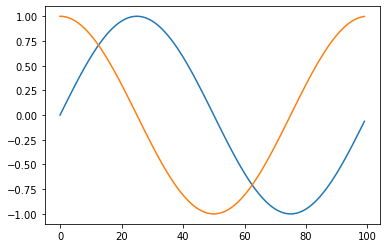

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
enc_t = TSCyclicalPosition()(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1] - 2
plt.plot(enc_t[0, -2:].cpu().numpy().T)
plt.show()

In [ ]:
#export
class TSLinearPosition(Transform):
    """Concatenates the position along the sequence as 1 additional variable
    
        Args:
            magnitude: added for compatibility. It's not used.
    """

    order = 90
    def __init__(self, magnitude=None, lin_range=(-1,1), **kwargs): 
        self.lin_range = lin_range
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor): 
        bs,_,seq_len = o.shape
        lin = linear_encoding(seq_len, device=o.device, lin_range=self.lin_range)
        output = torch.cat([o, lin.reshape(1,1,-1).repeat(bs,1,1)], 1)
        return output

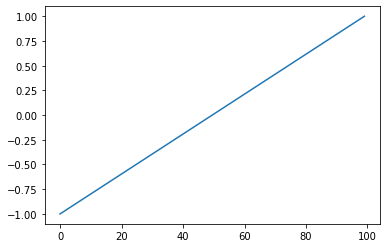

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
enc_t = TSLinearPosition()(t)
test_ne(enc_t, t)
assert t.shape[1] == enc_t.shape[1] - 1
plt.plot(enc_t[0, -1].cpu().numpy().T)
plt.show()

In [ ]:
# export
class TSPosition(Transform):
    """Concatenates linear and/or cyclical positions along the sequence as additional variables"""

    order = 90
    def __init__(self, cyclical=True, linear=True, magnitude=None, lin_range=(-1,1), **kwargs):
        self.lin_range = lin_range
        self.cyclical, self.linear = cyclical, linear
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        bs,_,seq_len = o.shape
        if self.linear:
            lin = linear_encoding(seq_len, device=o.device, lin_range=self.lin_range)
            o = torch.cat([o, lin.reshape(1,1,-1).repeat(bs,1,1)], 1)
        if self.cyclical:
            sin, cos = sincos_encoding(seq_len, device=o.device)
            o = torch.cat([o, sin.reshape(1,1,-1).repeat(bs,1,1), cos.reshape(1,1,-1).repeat(bs,1,1)], 1)
        return o

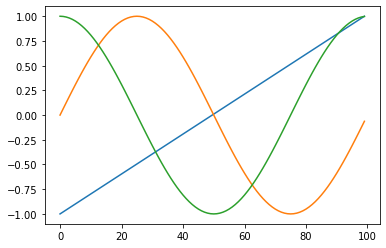

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
enc_t = TSPosition(cyclical=True, linear=True)(t)
test_eq(enc_t.shape[1], 6)
plt.plot(enc_t[0, 3:].T);

In [ ]:
#export
class TSMissingness(Transform):
    """Concatenates data missingness for selected features along the sequence as additional variables"""

    order = 90
    def __init__(self, feature_idxs=None, magnitude=None, **kwargs):
        self.feature_idxs = listify(feature_idxs)
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.feature_idxs:
            missingness = o[:, self.feature_idxs].isnan()
        else:
            missingness = o.isnan()
        return torch.cat([o, missingness], 1)

In [ ]:
bs, c_in, seq_len = 1,3,100
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t>.5] = np.nan
enc_t = TSMissingness(feature_idxs=[0,2])(t)
test_eq(enc_t.shape[1], 5)
test_eq(enc_t[:, 3:], torch.isnan(t[:, [0,2]]).float())

In [ ]:
#export
class TSPositionGaps(Transform):
    """Concatenates gaps for selected features along the sequence as additional variables"""

    order = 90
    def __init__(self, feature_idxs=None, magnitude=None, forward=True, backward=False, nearest=False, normalize=True, **kwargs):
        self.feature_idxs = listify(feature_idxs)
        self.gap_fn = partial(get_gaps, forward=forward, backward=backward, nearest=nearest, normalize=normalize)
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.feature_idxs:
            gaps = self.gap_fn(o[:, self.feature_idxs])
        else:
            gaps = self.gap_fn(o)
        return torch.cat([o, gaps], 1)


In [ ]:
bs, c_in, seq_len = 1,3,8
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t>.5] = np.nan
enc_t = TSPositionGaps(feature_idxs=[0,2], forward=True, backward=True, nearest=True, normalize=False)(t)
test_eq(enc_t.shape[1], 9)
enc_t.data

tensor([[[0.1138, 0.0972,    nan,    nan,    nan, 0.0759,    nan,    nan],
         [0.3392,    nan, 0.1070, 0.1759, 0.2476,    nan,    nan,    nan],
         [0.1099, 0.2954, 0.4379, 0.1218, 0.2740, 0.1492, 0.2985, 0.0275],
         [1.0000, 1.0000, 1.0000, 2.0000, 3.0000, 4.0000, 1.0000, 2.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 4.0000, 3.0000, 2.0000, 1.0000, 3.0000, 2.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 2.0000, 1.0000, 3.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]])

In [ ]:
#export
class TSRollingMean(Transform):
    """Calculates the rolling mean for all/ selected features alongside the sequence
    
       It replaces the original values or adds additional variables (default)
       If nan values are found, they will be filled forward and backward"""

    order = 90
    def __init__(self, feature_idxs=None, magnitude=None, window=2, replace=False, **kwargs):
        self.feature_idxs = listify(feature_idxs)
        self.rolling_mean_fn = partial(rolling_moving_average, window=window)
        self.replace = replace
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        if self.feature_idxs:
            if torch.isnan(o[:, self.feature_idxs]).any():
                o[:, self.feature_idxs] = fbfill_sequence(o[:, self.feature_idxs])
            rolling_mean = self.rolling_mean_fn(o[:, self.feature_idxs])
            if self.replace: 
                o[:, self.feature_idxs] = rolling_mean
                return o
        else:
            if torch.isnan(o).any():
                o = fbfill_sequence(o)
            rolling_mean = self.rolling_mean_fn(o)
            if self.replace: return rolling_mean
        return torch.cat([o, rolling_mean], 1)

In [ ]:
bs, c_in, seq_len = 1,3,8
t = TSTensor(torch.rand(bs, c_in, seq_len))
t[t > .6] = np.nan
print(t.data)
enc_t = TSRollingMean(feature_idxs=[0,2], window=3)(t)
test_eq(enc_t.shape[1], 5)
print(enc_t.data)
enc_t = TSRollingMean(window=3, replace=True)(t)
test_eq(enc_t.shape[1], 3)
print(enc_t.data)

tensor([[[   nan, 0.5947,    nan, 0.2073,    nan, 0.4581,    nan, 0.3850],
         [   nan, 0.1617, 0.3760, 0.4216,    nan, 0.3468,    nan, 0.1801],
         [0.2290,    nan,    nan, 0.2289,    nan, 0.1003, 0.0444,    nan]]])
tensor([[[0.5947, 0.5947, 0.5947, 0.2073, 0.2073, 0.4581, 0.4581, 0.3850],
         [   nan, 0.1617, 0.3760, 0.4216,    nan, 0.3468,    nan, 0.1801],
         [0.2290, 0.2290, 0.2290, 0.2289, 0.2289, 0.1003, 0.0444, 0.0444],
         [0.5947, 0.5947, 0.5947, 0.4656, 0.3364, 0.2909, 0.3745, 0.4337],
         [0.2290, 0.2290, 0.2290, 0.2289, 0.2289, 0.1860, 0.1245, 0.0630]]])
tensor([[[0.5947, 0.5947, 0.5947, 0.4656, 0.3364, 0.2909, 0.3745, 0.4337],
         [0.1617, 0.1617, 0.2331, 0.3198, 0.4064, 0.3967, 0.3717, 0.2912],
         [0.2290, 0.2290, 0.2290, 0.2289, 0.2289, 0.1860, 0.1245, 0.0630]]])


In [ ]:
#export
class TSLogReturn(Transform):
    "Calculates log-return of batch of type `TSTensor`. For positive values only"
    order = 90
    def __init__(self, lag=1, pad=True, **kwargs):
        super().__init__(**kwargs)
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor):
        return torch_diff(torch.log(o), lag=self.lag, pad=self.pad)

    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,4,8,16,32,64,128,256]).float()
test_eq(TSLogReturn(pad=False)(t).std(), 0)

In [ ]:
#export
class TSAdd(Transform):
    "Add a defined amount to each batch of type `TSTensor`."
    order = 90
    def __init__(self, add, **kwargs):
        super().__init__(**kwargs)
        self.add = add

    def encodes(self, o:TSTensor):
        return torch.add(o, self.add)
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,3]).float()
test_eq(TSAdd(1)(t), TSTensor([2,3,4]).float())

In [ ]:
#export
class TSClipByVar(Transform):
    """Clip  batch of type `TSTensor` by variable
    
    Args:
        var_min_max: list of tuples containing variable index, min value (or None) and max value (or None)
    """
    order = 90
    def __init__(self, var_min_max, **kwargs):
        super().__init__(**kwargs)
        self.var_min_max = var_min_max

    def encodes(self, o:TSTensor):
        for v,m,M in self.var_min_max:
            o[:, v] = torch.clamp(o[:, v], m, M)
        return o

In [ ]:
t = TSTensor(torch.rand(16, 3, 10) * tensor([1,10,100]).reshape(1,-1,1))
max_values = t.max(0).values.max(-1).values.data
max_values2 = TSClipByVar([(1,None,5), (2,10,50)])(t).max(0).values.max(-1).values.data
test_le(max_values2[1], 5)
test_ge(max_values2[2], 10)
test_le(max_values2[2], 50)

# sklearn API transforms

In [ ]:
#export
from sklearn.base import BaseEstimator, TransformerMixin
from fastai.data.transforms import CategoryMap
from joblib import dump, load


class TSShrinkDataFrame(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, skip=[], obj2cat=True, int2uint=False, verbose=True):
        self.columns, self.skip, self.obj2cat, self.int2uint, self.verbose = listify(columns), skip, obj2cat, int2uint, verbose
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        self.old_dtypes = X.dtypes            
        if not self.columns: self.columns = X.columns
        self.dt = df_shrink_dtypes(X[self.columns], self.skip, obj2cat=self.obj2cat, int2uint=self.int2uint)
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        if self.verbose:
            start_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe is {start_memory} MB")
        X[self.columns] = X[self.columns].astype(self.dt)
        if self.verbose:
            end_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe after reduction {end_memory} MB")
            print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
        return X
         
    def inverse_transform(self, X):
        assert isinstance(X, pd.DataFrame)
        if self.verbose:
            start_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe is {start_memory} MB")
        X = X.astype(self.old_dtypes)
        if self.verbose:
            end_memory = X.memory_usage().sum() / 1024**2
            print(f"Memory usage of dataframe after reduction {end_memory} MB")
            print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
        return X


In [ ]:
df = pd.DataFrame()
df["ints64"] = np.random.randint(0,3,10)
df['floats64'] = np.random.rand(10)
tfm = TSShrinkDataFrame()
tfm.fit(df)
df = tfm.transform(df)
test_eq(df["ints64"].dtype, "int8")
test_eq(df["floats64"].dtype, "float32")

Memory usage of dataframe is 0.000274658203125 MB
Memory usage of dataframe after reduction 0.0001697540283203125 MB
Reduced by 38.19444444444444 % 


In [ ]:
#export
class TSOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, drop=True, add_na=True, dtype=np.int64):
        self.columns = listify(columns)
        self.drop, self.add_na, self.dtype = drop, add_na, dtype
        

    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        handle_unknown = "ignore" if self.add_na else "error"
        self.ohe_tfm = sklearn.preprocessing.OneHotEncoder(handle_unknown=handle_unknown)
        if len(self.columns) == 1:
            self.ohe_tfm.fit(X[self.columns].to_numpy().reshape(-1, 1))
        else: 
            self.ohe_tfm.fit(X[self.columns])
        return self

    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        if len(self.columns) == 1:
            output = self.ohe_tfm.transform(X[self.columns].to_numpy().reshape(-1, 1)).toarray().astype(self.dtype)
        else: 
            output = self.ohe_tfm.transform(X[self.columns]).toarray().astype(self.dtype)
        new_cols = []
        for i,col in enumerate(self.columns): 
            for cats in self.ohe_tfm.categories_[i]:
                new_cols.append(f"{str(col)}_{str(cats)}")
        X[new_cols] = output
        if self.drop: X = X.drop(self.columns, axis=1)
        return X


In [ ]:
df = pd.DataFrame()
df["a"] = np.random.randint(0,2,10)
df["b"] = np.random.randint(0,3,10)
unique_cols = len(df["a"].unique()) + len(df["b"].unique())
tfm = TSOneHotEncoder()
tfm.fit(df)
df = tfm.transform(df)
test_eq(df.shape[1], unique_cols)

In [ ]:
#export
class TSCategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, add_na=True):
        self.columns = listify(columns)
        self.add_na = add_na

    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        self.cat_tfms = []
        for column in self.columns: 
            self.cat_tfms.append(CategoryMap(X[column], add_na=self.add_na))
        return self

    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        for cat_tfm, column in zip(self.cat_tfms, self.columns): 
            X[column] = cat_tfm.map_objs(X[column])
        return X
    
    def inverse_transform(self, X):
        assert isinstance(X, pd.DataFrame)
        for cat_tfm, column in zip(self.cat_tfms, self.columns): 
            X[column] = cat_tfm.map_ids(X[column])
        return X

Stateful transforms like TSCategoricalEncoder can easily be serialized. 

In [ ]:
import joblib
df = pd.DataFrame()
df["a"] = alphabet[np.random.randint(0,2,100)]
df["b"] = ALPHABET[np.random.randint(0,3,100)]
a_unique = len(df["a"].unique())
b_unique = len(df["b"].unique())
tfm = TSCategoricalEncoder()
tfm.fit(df)
joblib.dump(tfm, "data/TSCategoricalEncoder.joblib")
tfm = joblib.load("data/TSCategoricalEncoder.joblib")
df = tfm.transform(df)
test_eq(df['a'].max(), a_unique)
test_eq(df['b'].max(), b_unique)

In [ ]:
#export
default_date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
                     'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

class TSDateTimeEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, datetime_columns=None, prefix=None, drop=True, time=False, attr=default_date_attr):
        self.datetime_columns = listify(datetime_columns)
        self.prefix, self.drop, self.time, self.attr = prefix, drop, time ,attr
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if self.time: self.attr = self.attr + ['Hour', 'Minute', 'Second']
        if not self.datetime_columns:
            self.datetime_columns = X.columns
        self.prefixes = []
        for dt_column in self.datetime_columns: 
            self.prefixes.append(re.sub('[Dd]ate$', '', dt_column) if self.prefix is None else self.prefix)
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        
        for dt_column,prefix in zip(self.datetime_columns,self.prefixes): 
            make_date(X, dt_column)
            field = X[dt_column]

            # Pandas removed `dt.week` in v1.1.10
            week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
            for n in self.attr: X[prefix + "_" + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
            if self.drop: X = X.drop(self.datetime_columns, axis=1)
        return X

In [ ]:
import datetime
df = pd.DataFrame()
df.loc[0, "date"] = datetime.datetime.now()
df.loc[1, "date"] = datetime.datetime.now() + pd.Timedelta(1, unit="D")
tfm = TSDateTimeEncoder()
joblib.dump(tfm, "data/TSDateTimeEncoder.joblib")
tfm = joblib.load("data/TSDateTimeEncoder.joblib")
tfm.fit_transform(df)

,_Year,_Month,_Week,_Day,_Dayofweek,_Dayofyear,_Is_month_end,_Is_month_start,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start
0,2022,3,11,17,3,76,False,False,False,False,False,False
1,2022,3,11,18,4,77,False,False,False,False,False,False


In [ ]:
#export
class TSMissingnessEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = listify(columns)
        
    def fit(self, X:pd.DataFrame, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        if not self.columns: self.columns = X.columns
        self.missing_columns = [f"{cn}_missing" for cn in self.columns]
        return self
        
    def transform(self, X:pd.DataFrame, y=None, **transform_params):
        assert isinstance(X, pd.DataFrame)
        X[self.missing_columns] = X[self.columns].isnull().astype(int)
        return X
         
    def inverse_transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X.drop(self.missing_columns, axis=1, inplace=True)
        return X

In [ ]:
data = np.random.rand(10,3)
data[data > .8] = np.nan
df = pd.DataFrame(data, columns=["a", "b", "c"])
tfm = TSMissingnessEncoder()
tfm.fit(df)
joblib.dump(tfm, "data/TSMissingnessEncoder.joblib")
tfm = joblib.load("data/TSMissingnessEncoder.joblib")
df = tfm.transform(df)
df

,a,b,c,a_missing,b_missing,c_missing
0,0.469540,0.012972,NaN,0,0,1
1,0.105679,0.783798,0.002399,0,0,0
2,0.784889,0.713163,NaN,0,0,1
3,0.078412,0.237226,NaN,0,0,1
4,0.017181,0.189451,0.320101,0,0,0
5,0.122962,NaN,0.306841,0,1,0
6,0.315652,0.269706,0.359104,0,0,0
7,0.363839,0.404924,NaN,0,0,1
8,0.731260,NaN,0.124986,0,1,0
9,0.451528,0.600763,0.223294,0,0,0


## y transforms

In [ ]:
# export
class Preprocessor():
    def __init__(self, preprocessor, **kwargs): 
        self.preprocessor = preprocessor(**kwargs)
        
    def fit(self, o): 
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        self.fit_preprocessor = self.preprocessor.fit(o)
        return self.fit_preprocessor
    
    def transform(self, o, copy=True):
        if type(o) in [float, int]: o = array([o]).reshape(-1,1)
        o_shape = o.shape
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        output = self.fit_preprocessor.transform(o).reshape(*o_shape)
        if isinstance(o, torch.Tensor): return o.new(output)
        return output
    
    def inverse_transform(self, o, copy=True):
        o_shape = o.shape
        if isinstance(o, pd.Series): o = o.values.reshape(-1,1)
        else: o = o.reshape(-1,1)
        output = self.fit_preprocessor.inverse_transform(o).reshape(*o_shape)
        if isinstance(o, torch.Tensor): return o.new(output)
        return output


StandardScaler = partial(sklearn.preprocessing.StandardScaler)
setattr(StandardScaler, '__name__', 'StandardScaler')
RobustScaler = partial(sklearn.preprocessing.RobustScaler)
setattr(RobustScaler, '__name__', 'RobustScaler')
Normalizer = partial(sklearn.preprocessing.MinMaxScaler, feature_range=(-1, 1))
setattr(Normalizer, '__name__', 'Normalizer')
BoxCox = partial(sklearn.preprocessing.PowerTransformer, method='box-cox')
setattr(BoxCox, '__name__', 'BoxCox')
YeoJohnshon = partial(sklearn.preprocessing.PowerTransformer, method='yeo-johnson')
setattr(YeoJohnshon, '__name__', 'YeoJohnshon')
Quantile = partial(sklearn.preprocessing.QuantileTransformer, n_quantiles=1_000, output_distribution='normal', random_state=0)
setattr(Quantile, '__name__', 'Quantile')

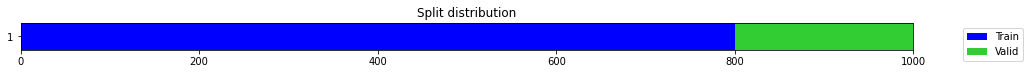

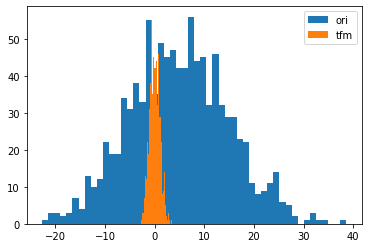

In [ ]:
# Standardize
from tsai.data.validation import TimeSplitter
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(StandardScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

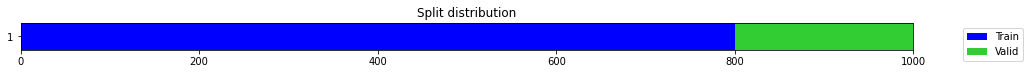

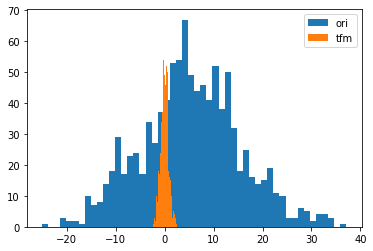

In [ ]:
# RobustScaler
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(RobustScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

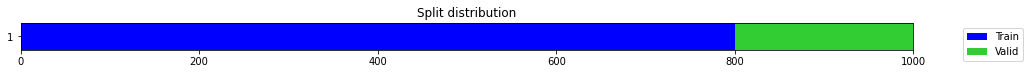

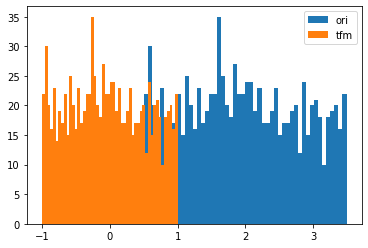

In [ ]:
# Normalize
y = random_shuffle(np.random.rand(1000) * 3 + .5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(Normalizer)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

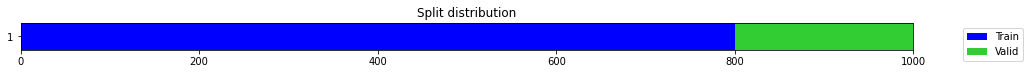

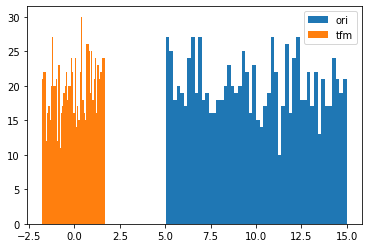

In [ ]:
# BoxCox
y = random_shuffle(np.random.rand(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(BoxCox)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

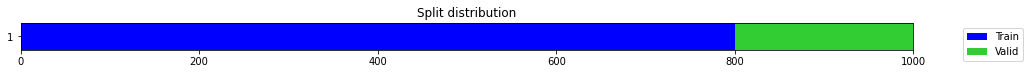

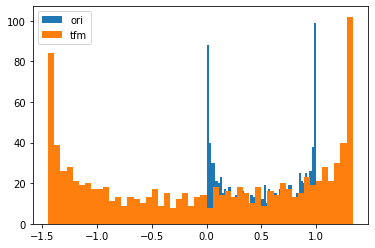

In [ ]:
# YeoJohnshon
y = random_shuffle(np.random.randn(1000) * 10 + 5)
y = np.random.beta(.5, .5, size=1000)
splits = TimeSplitter()(y)
preprocessor = Preprocessor(YeoJohnshon)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

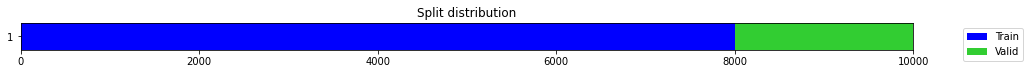

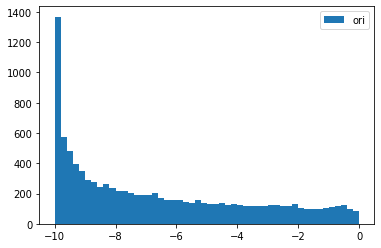

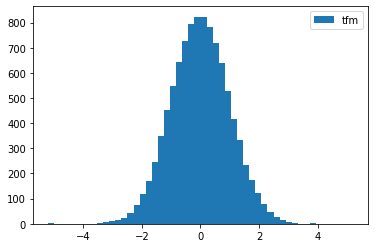

In [ ]:
# QuantileTransformer
y = - np.random.beta(1, .5, 10000) * 10
splits = TimeSplitter()(y)
preprocessor = Preprocessor(Quantile)
preprocessor.fit(y[splits[0]])
plt.hist(y, 50, label='ori',)
y_tfm = preprocessor.transform(y)
plt.legend(loc='best')
plt.show()
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()
test_close(preprocessor.inverse_transform(y_tfm), y, 1e-1)

In [ ]:
#export
def ReLabeler(cm):
    r"""Changes the labels in a dataset based on a dictionary (class mapping) 
        Args:
            cm = class mapping dictionary
    """
    def _relabel(y):
        obj = len(set([len(listify(v)) for v in cm.values()])) > 1
        keys = cm.keys()
        if obj: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y], dtype=object).reshape(*y.shape)
        else: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y]).reshape(*y.shape)
    return _relabel

In [ ]:
vals = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}
y = np.array([vals[i] for i in np.random.randint(0, 5, 20)])
labeler = ReLabeler(dict(a='x', b='x', c='y', d='z', e='z'))
y_new = labeler(y)
test_eq(y.shape, y_new.shape)
y, y_new

(array(['e', 'a', 'd', 'b', 'd', 'c', 'b', 'a', 'b', 'c', 'b', 'c', 'd',
        'a', 'c', 'b', 'b', 'e', 'c', 'a'], dtype='<U1'),
 array(['z', 'x', 'z', 'x', 'z', 'y', 'x', 'x', 'x', 'y', 'x', 'y', 'z',
        'x', 'y', 'x', 'x', 'z', 'y', 'x'], dtype='<U1'))

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

016_data.preprocessing.ipynb saved at 2022-03-17 21:03:06.
Converted 016_data.preprocessing.ipynb.


Correct conversion! 😃
Total time elapsed 0.104 s
Thursday 17/03/22 21:03:11 CET
